## Motivation
Proper audience targeting is a critical component of a successful advertising campaign. This study aims to identify customer demographics that may be particularly receptive to Game Revenant's (GR) advertising, specifically to optimize social media-based campaigns.

Due to their large reach and popularity, Facebook, Instagram, and Twitter can be an effective means of reaching new audiences. Facebook (which own Instagram) and Twitter both offer APIs that allow businesses to target their advertisements based on a number of demographic features, such as age, gender, language, location, and interests. There are a few differences in the targeting options available between Facebook and Twitter. Facebook can target by profession and behavior, while Twitter can target based on a list of Twitter profiles. [fill in

here we target based on interest

Analysis is performed on unstructured social media data, specifically from Twitter. Compared to other social media, Twitter's API allows greater access to user data, enabling more effective data mining. GR currently has too few followers on Twitter to allow for productive data mining. However, the Twitter accounts of rival companies can be analyzed as well. Where Shadows Slumber (WSS) is frequently compared to Monument Valley, a mobile puzzle game produced by USTWO Games, by game critics and customer reviewers. As of this writing, @ustwogames has over 126k followers.

Customer interests were estimated by 1) examining the profile description of @ustogames followers, and 2) examining the most popular friends among @ustogames followers. Preprocessed descriptions were examined via two clustering approches, K-modes and DBSCAN. In Twitter's official terminology, a 'friend' is an account a user follows. The most popular friends were clustered via K-modes. The rationale behind the unorthodox application of K-modes will be explained later in the notebook

## Methods and Results

Profiles of games on the iTunes App Store (https://apps.apple.com/us/genre/ios-games/id6014) were scraped using the python package Scrapy. Game profiles were stored in a SQLite database, in a table named after the genre section they were scrapped from. Note that a game can appear in multiple genre sections. The web scraping code may be found in [].

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlalchemy as sa


In [2]:
# Autoreload to accomodate script updates without restarting notebook
%load_ext autoreload
%autoreload 2 
# Move to main directory of the Customer-Segmentation project
%cd ..

C:\Users\Vincent\Game-Revenant\Where-Shadows-Slumber\App-Store-Analysis


In [2]:
from pathlib import Path

# Pull interim data from SQLite DB

DB_NAME = 'app-store'
e = sa.create_engine('sqlite:///./data/interim/app-store.sqlite')
query = '''
        SELECT *, 'action' AS genre FROM iosaction UNION
        SELECT *, 'adventure' FROM iosadventure UNION
        SELECT *, 'board' FROM iosboard UNION
        SELECT *, 'card' FROM ioscard UNION 
        SELECT *, 'casino' FROM ioscasino UNION
        SELECT *, 'casual' FROM ioscasual UNION
        SELECT *, 'family' FROM iosfamily UNION
        SELECT *, 'music' FROM iosmusic UNION
        SELECT *, 'puzzle' FROM iospuzzle UNION
        SELECT *, 'racing' FROM iosracing UNION
        SELECT *, 'rpg' FROM iosrpg UNION
        SELECT *, 'simulation' FROM iossimulation UNION
        SELECT *, 'sports' FROM iossports UNION 
        SELECT *, 'strategy'FROM iosstrategy UNION 
        SELECT *, 'trivia' FROM iostrivia UNION
        SELECT *, 'word' FROM iosword
        '''
apps = pd.read_sql_query(query, e)

Loading the data, it is apparent that the data needs be cleaned. Each field is populated by strings, and not all entries were available for each game profile. A sample of the raw data is shown below. 

In [3]:
apps.head()
apps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380969 entries, 0 to 380968
Data columns (total 20 columns):
age          380969 non-null object
age_copy     380969 non-null object
author       380690 non-null object
category     380969 non-null object
compat       380969 non-null object
desc         380969 non-null object
editor       1384 non-null object
iap          148075 non-null object
lang         380969 non-null object
list_rank    11006 non-null object
nrating      234417 non-null object
price        380896 non-null object
score        234417 non-null object
seller       380969 non-null object
size         380969 non-null object
stars        234417 non-null object
subtitle     121114 non-null object
support      380969 non-null object
title        380969 non-null object
genre        380969 non-null object
dtypes: object(20)
memory usage: 58.1+ MB


### Data cleaning

Each feature is defined and described in the code cell below, as well as the processing required to organize the raw data into continuous and categorical variables. Cleaning can take some time, to the formatted data set is saved into a database at the end of the code cell.

In [11]:
import re

# age (categorical)
# Age rating for game. Dummy encoded.
# Categories are 4+, 9+, 12+, 17+

age_encoded = pd.get_dummies(apps['age'])
age_encoded.columns = ['age_' + col.replace('+','') for col in age_encoded.columns]
apps = pd.concat([apps, age_encoded], axis=1)
apps = apps.drop(columns=['age'])

# age_copy (str)
# Long string containing a variety information, including age rating, memory size, copyright information. 
# Was initially scraped to get the copyright year, to give estimate of release date. 
# Copyright year is not included frequently enough, however, so this category was dropped

apps = apps.drop(columns=['age_copy'])

# author (str)
# Author of game. Can be used to consolidate duplicate game titles

# category (categorical)
# Category of app. Data was scrapped from game storefront, so everything should be listed as 'Games'
# There are a few cases where this was not true (e.g. classified as 'Education', or 'Music')
# Only concerned with game releases, so we filter for these specifically

apps = apps[apps['category'] == 'Games']
apps = apps.drop(columns=['category'])

# compat (ordinal)
# Compatibility of the app. Interested primarily in the minimum OS release requirements. 
# There are 409 different OS version releases (including minor releases), so we confine our search to major software versions

# Very few cases don't contain compatibility information; filter these out
apps = apps.dropna(subset=['compat']) 
# All version requirements starts with the phrase, 'Requires iOS x.x. or later'. First filter for that phrase
apps['compat'] = apps['compat'].apply(lambda compat: re.findall(r'Requires\siOS\s\d+', compat)) 
# Pull out just the major iOS release version. 
apps['compat'] = apps['compat'].apply(lambda compat: int(re.findall(r'\d+', compat[0])[0]) if compat else None)
# Also filter out apps that are not on iOS (few Apple TV apps)
apps = apps.dropna(subset=['compat']) 

# desc (str)
# Description of app. May be interesting to analyze for keywords in the future.
# Out-of-scope for this analysis, so it's dropped

apps = apps.drop(columns=['desc'])

# editor (boolean)
# Indicates whether the game was notable enough to receive an 'Editor's Choice' or 'Editor's Note' designation
# These recognized games are on the front page most often, and the App Store will promote these apps particularly

apps['editor'] = apps['editor'].apply(lambda editor: True if editor else False)

# genre (categorical)
# Genre of game, based on the page on which the title was scrapped from. Dummy encoded
# Note that games can be a part of multiple genres
# This was assigned in the SQL code a previous cell. 

genre_encoded = pd.get_dummies(apps['genre'])
genre_encoded.columns = ['gen_' + col.lower() for col in genre_encoded.columns]
apps = pd.concat([apps, genre_encoded], axis=1)
apps = apps.drop(columns=['genre'])

# iap (boolean)
# Indicates whether the game contains in-app purchases

apps['iap'] = apps['iap'].replace('Offers In-App Purchases', True).fillna(False)

# lang (categorical)
# Languages the game is available in. Dummy encoded
# Hyperparameter 'thresh' limits the number of language categories based on popularity

# new category counts number of languages the game is available in
apps['lang_cnt'] = apps['lang'].apply(lambda lang: len(lang.split(', ')))

lang_encoded = apps['lang'].str.get_dummies(', ')
thresh = 0.05 * len(apps)
thresh_list = (lang_encoded.sum(axis=0) < thresh).to_list()
ind_drop = np.where(thresh_list)
lang_encoded = lang_encoded.drop(lang_encoded.columns[ind_drop], axis=1)
lang_encoded.columns = ['lang_' + col.replace(' ','_').lower() for col in lang_encoded.columns]

apps = pd.concat([apps, lang_encoded], axis=1)
apps = apps.drop(columns=['lang'])

# list_rank (boolean)
# Typically the rank of the game within a given category (assuming the game is ranked)
# Field is not strictly limited to rank: it can also contain hardware restrictions ('Only for Apple TV'). 
# Anticipated release dates can also be found in this field.
# Initially seemed like a promising predictive feature, but upon inspection of the data, the ranking system is not consistent.
# Games can appear in different genre pages, and be ranked in other genres. Value of rank is inconsistent as well.
# Due to the inconsistency of this metric, it was simplified into a boolean: ranked, or not

apps['list_rank'] = apps['list_rank'].fillna('').apply(lambda rank: True if re.findall(r'#', rank) else False)

# nrating (numeric)
# Number ratings the game received

apps['nrating'] = apps['nrating'].fillna('0.0') # account for games that haven't been rated
# In raw form, if the review count is over a thousand or a million, the abbreviation 'K' or 'M' is used
apps['in_K'] = apps['nrating'].apply(lambda nrating: True if re.findall(r'K', nrating) else False)
apps['in_M'] = apps['nrating'].apply(lambda nrating: True if re.findall(r'M', nrating) else False)
apps['nrating'] = apps['nrating'].apply(lambda nrating: float(re.findall(r'[\d\.]+', nrating)[0]))
apps['nrating'] = apps.apply(lambda app: 1e3*app['nrating'] 
                             if app['in_K'] == True 
                             else app['nrating'], axis=1)
apps['nrating'] = apps.apply(lambda app: 1e6*app['nrating'] 
                             if app['in_M'] == True 
                             else app['nrating'], axis=1)
apps = apps.drop(columns=['in_K', 'in_M'])

# price (numeric)
# Price of game

# we also drop a few cases (73) where a price wasn't listed
apps = apps.dropna(subset=['price'])
apps['price'] = apps['price'].apply(lambda price: float(re.findall(r'[\d\.]+', price)[0]) 
                                    if price != 'Free' 
                                    else 0.0)

# score (numeric)
# Mean score across all ratings. Games that have not been rated will have a NaN assigned in this field

apps['score'] = apps['score'].fillna(np.nan).apply(float)

# seller (str)
# Party that sells the game, usually same as author. Dropped in this project

apps = apps.drop(columns=['seller'])

# size (float)
# Size of game, in MB. Games that are in KB are rounded to 1.0 MB

apps['in_KB'] = apps['size'].apply(lambda nrating: True if re.findall(r'KB', nrating) else False)
apps['in_GB'] = apps['size'].apply(lambda nrating: True if re.findall(r'GB', nrating) else False)
apps['size'] = apps['size'].apply(lambda nrating: float(re.findall(r'[\d\.]+', nrating)[0]))
apps['size'] = apps.apply(lambda app: 1.0
                             if app['in_KB'] == True 
                             else app['size'], axis=1)
apps['size'] = apps.apply(lambda app: 1e3*app['size'] 
                             if app['in_GB'] == True 
                             else app['size'], axis=1)
apps = apps.drop(columns=['in_KB', 'in_GB'])

# stars (numerical)
# Rating breakdown for the game
# Split into multiple categories, one for each possible rating

apps['stars'] = apps['stars'].apply(lambda rating: re.findall(r'\d+', rating)
                                    if rating is not None 
                                    else [0, 0, 0, 0, 0])
apps['star5'] = apps['stars'].apply(lambda rating: float(rating[0]))
apps['star4'] = apps['stars'].apply(lambda rating: float(rating[1]))
apps['star3'] = apps['stars'].apply(lambda rating: float(rating[2]))
apps['star2'] = apps['stars'].apply(lambda rating: float(rating[3]))
apps['star1'] = apps['stars'].apply(lambda rating: float(rating[4]))
apps = apps.drop(columns=['stars'])

# subtitle (str)
# Subtitle of game, if it exists. 
# Could be useful in the future of keyword analysis, but dropped for now

apps = apps.drop(columns=['subtitle'])

# support (categorical)
# iOS supports features such as 'Family Center' and 'Game Center' which can augment a user's experience

# one-hot enocde supports category
supports_encoded = apps['support'].str.get_dummies(',')
supports_encoded.columns = ['sup_' + col.replace(' ','_').lower() for col in supports_encoded.columns]
apps = pd.concat([apps, supports_encoded], axis=1)
apps = apps.drop(columns=['support'])

# title (str)
# Title of game
# Games can be scrapped multiple times since they can be posted on multiple genre pages
# Title can be used to consolidate these duplicates

def agg_func(x):
    '''Dictate the aggregate function to apply based on the data object type

    param x: DataFrame groupby object
    '''
    if x.dtype in ('float64', 'object'):
        return x.mean()
    elif x.dtype in ('bool', 'uint8', 'int64'):
        return x.max()
    else:
        print('Unrecognized dtype!')

# Duplicate game titles can contain different rating and star values. These are will be averaged
# Boolean and integer values are dummy categories, so we mark as True/1 if so in at least one row
apps = apps.groupby(['title','author']).agg(agg_func).reset_index()


# Once date has been cleaned, we can save the data set to a DB
e = sa.create_engine('sqlite:///./data/interim/app-store.sqlite')
apps.to_sql('iosformatted', e, if_exists='replace', index=False)

KeyError: 'age'

### Generating training and testing sets

Summary of the formatted data shows that, except for the title and author of the game, each feature has been transformed into a continuous variable (dtype=float64) or a dummy-encoded categorical variable (dtype=int64). Furthermore, the missing values have been accounted for or filled in, and every conlumn (except for *score*) contains the same number of value. The *score* feature contains NaN values for games that received no ratings. 

In [444]:
e = sa.create_engine('sqlite:///./data/interim/app-store.sqlite')
apps = pd.read_sql_query('SELECT * FROM iosformatted', e)
apps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195732 entries, 0 to 195731
Data columns (total 56 columns):
title                       195732 non-null object
author                      195732 non-null object
compat                      195732 non-null float64
editor                      195732 non-null int64
iap                         195732 non-null int64
list_rank                   195732 non-null int64
nrating                     195732 non-null float64
price                       195732 non-null float64
score                       119988 non-null float64
size                        195732 non-null float64
age_12                      195732 non-null int64
age_17                      195732 non-null int64
age_4                       195732 non-null int64
age_9                       195732 non-null int64
gen_action                  195732 non-null int64
gen_adventure               195732 non-null int64
gen_board                   195732 non-null int64
gen_card                   

The target variable in this analysis is the number of ratings the game received (*nrating*). Quartile analysis can give quick overview of the data distribution of *nrating*.

count    1.957320e+05
mean     6.533230e+02
std      1.787270e+04
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      8.000000e+00
max      4.500000e+06
Name: nrating, dtype: float64

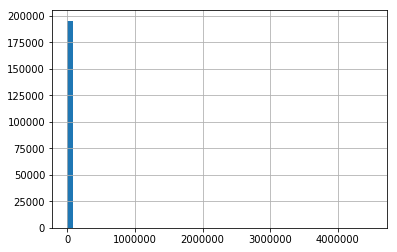

In [445]:
apps['nrating'].hist(bins=50)
apps['nrating'].describe()

The target variable is heavily skewed, with most games receiving very few reviews (if they receive any reviews at all). 

Incorporating such a large number of unpopular games into the analysis may hamper the model's ability to predict a games popularity by pulling the target values to be lower. Furthermore, we're primarily interested in WSS's performance against games with a similiar or greater level of success (as measured by ratings count). The data was filtered only to include games that had more than 36 reviews. At this threshold, the number of WSS ratings (175) would approximately be located at the median of the ratings distribution. 

In [446]:
apps[apps['title']=='Where Shadows Slumber'][['title','nrating']]

,title,nrating
187663,Where Shadows Slumber,175.0


In [447]:
apps = apps[ (apps['nrating']>36)]
apps['nrating'].describe()

count    2.559300e+04
mean     4.974343e+03
std      4.920964e+04
min      3.650000e+01
25%      7.100000e+01
50%      1.760000e+02
75%      7.255000e+02
max      4.500000e+06
Name: nrating, dtype: float64

Given the skewness of the ratings distribution, it's critical that stratified sampling be employed when splitting the data into training and testing sets. The data is separated into five bins. 

In [448]:
from sklearn.model_selection import StratifiedShuffleSplit

bins = [36, 100, 1000, 10000, 100000, np.inf]
labels=[1, 2, 3, 4, 5]
# create a new column containing the ratings bin the game is associated with
apps['nrating_cut'] = pd.cut(apps['nrating'], bins=bins, labels=labels)

# split data into training (80%) and testing (20%) sets
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_ind, test_ind in split.split(apps, apps['nrating_cut']):
    train_set, test_set = apps.iloc[train_ind], apps.iloc[test_ind]

In [385]:
# optionally save training and testing sets to database

# e = sa.create_engine('sqlite:///./data/processed/app-store.sqlite')
# test_set.to_sql('test_set', e, if_exists='replace')
# train_set.to_sql('train_set', e, if_exists='replace')

The target variable is separated from the feature set, as well as the string features (title and author) that will not be used for prediction. 

In [478]:
test_label = test_set['nrating'].copy()
test_identity = test_set[['title','author']].copy()
test_set = test_set.drop(columns=['nrating_cut','nrating','title','author','list_rank'])

train_label = train_set['nrating'].copy()
train_identity = train_set[['title','author']].copy()
train_set_binned = train_set['nrating_cut'].copy() # label identifying the ratings bin the game occupies
train_set = train_set.drop(columns=['nrating_cut','nrating','title','author','list_rank']) 

# get index of numeric features (as opposed to categorical features) that will need to be preprocesse
numeric_feat = train_set.dtypes[train_set.dtypes == 'float64'].index

### Processing Pipeline

The distribution of the numeric features is highly skewed. Most models operate best when the features are normally distributed, so corrections must be applied on these features. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000003E522470>,
      dtype=object)

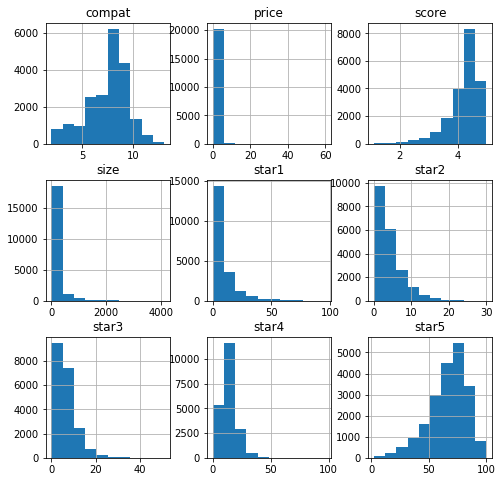

In [232]:
train_set[numeric_feat].hist(bins=10, figsize=(8,8))

To streamline skew correction, a custom transformer is created in conjunction with a data pipeline. The pipeline also implements StandardScalar, which normalizes the features to have a mean of 0 and standard deviation of 1. 

In [221]:
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import skew
from scipy.stats import boxcox


class SkewCorrector(BaseEstimator, TransformerMixin):
    
    def __init__(self, skew_bound=0.2): # skew_bound is amount of skew that is acceptable
        self.skew_bound = skew_bound
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_val = X.to_numpy()
        
        # different distributions require different transforms; indicies are defined below for specific data types
        ind_skewed = np.absolute(skew(X_val)) > self.skew_bound
        ind_right_skew = skew(X_val) > 0
        ind_left_skew = skew(X_val) < 0
        ind_no_zeros = [0 not in X_val[:,col] for col in np.arange(X_val.shape[1])]
        ind_has_zeros = [0 in X_val[:,col] for col in np.arange(X_val.shape[1])]
        # if all elements in a feature column are positive, the sum of all those should be equal to the number of rows in that feature matrix
        ind_positive = [np.sign(X_val[:,col]).sum() == X_val.shape[0] for col in np.arange(X_val.shape[1])]

        # transform right and left skewed data that does not include zero values with boxcox
        X_trans, _ = np.apply_along_axis(boxcox, 0, X_val[:,ind_skewed & ind_no_zeros & ind_positive]) # returns list of arrays
        X_val[:,ind_skewed & ind_no_zeros & ind_positive] = np.vstack(X_trans).T
        
        # transform right skewed data that contains zero values with log plus one
        X_trans = np.log1p(X_val[:,ind_skewed & ind_right_skew & ind_has_zeros])
        X_val[:,ind_skewed * ind_right_skew * ind_has_zeros] = X_trans
        
        # transform left skewed data that contains zero values by increasing power incrementally
        for pwr in range(2, 5): #arbitarily set the power limit to 5; maybe make this a user-defined parameter?
            X_trans = X_val[:,ind_skewed * ind_left_skew * ind_has_zeros]**pwr
            if skew(X_trans) < self.skew_bound:
                break
        
        X_val[:,ind_skewed * ind_left_skew * ind_has_zeros] = X_trans
        
        # Update the input data frame with transformed values
        X_out = pd.DataFrame(X_val, index=X.index, columns=X.columns)
        return X_out
        
        

In [222]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

num_pipeline = Pipeline([
    ('trans_skew', SkewCorrector(skew_bound=0.2)),
    ('std_scaler', StandardScaler())
])

numeric_feat = train_set.dtypes[train_set.dtypes == 'float64'].index
cat_feat = train_set.dtypes[train_set.dtypes != 'float64'].index


full_pipeline = ColumnTransformer([
    ('num', num_pipeline, numeric_feat)
])

Plotting the numeric features after preprocessing indicates that most of the distributions have become approximately normal. Note that *price* is still heavily skewed: almost all games have a price of $0.00.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000050B29A90>,
      dtype=object)

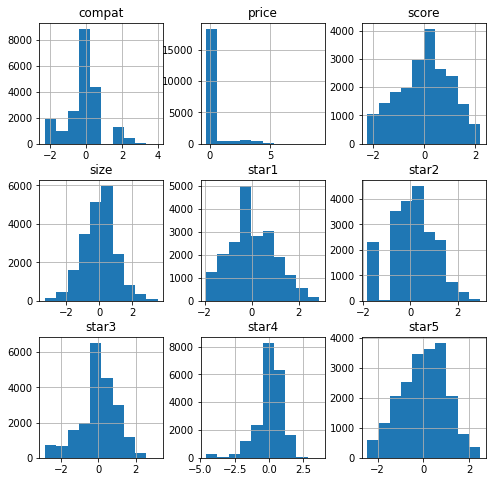

In [223]:
train_set_processed = train_set.copy()

train_set_processed[numeric_feat] = full_pipeline.fit_transform(train_set[numeric_feat])
train_set_processed[numeric_feat].hist(bins=10, figsize=(8,8))

# train_set_processed = train_set_processed.drop(columns=['nrating_cut'])

### Model training and selection

Once the processing pipeline is complete, the training data can now be fitted. A number of different models were tried, mostly using the default hyperparameters. 

The following regressors were evaluated: linear regression, elastic net, stochastic gradient descent, linear support vector, k-nearest neighbor, random forest, and gradient tree boosting. 

Prior to cross validation, stratified sampling was used to ensure that the training and validation folds had similiar ratings distributions (in the same way stratified sampling was used to separate the initial data set into training and testing sets). 

In [224]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from functools import partial
    
def init_cv_gen():
    '''Helper function that returns a generator for cross-validation'''
    skf = StratifiedKFold(10, shuffle=True, random_state=42).split(train_set_processed, train_set_binned)
    return skf

def cv_score(estimator):
    '''Generates cross validation scores; used to keep code clean when testing different models (estimator)'''
    cv = init_cv_gen()
    cv_score = cross_val_score(estimator=estimator, X=train_set_processed, y=train_label, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1)
    return cv_score

def show_cv_result(scores):
    '''Print mean and standard deviation of an array of cross validation scores'''
    print(f'Cross validation mean score is : {np.mean(scores)} ± {np.std(scores)}')

In [225]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(train_set_processed, train_label)

scores = cv_score(reg)
show_cv_result(-scores)

Cross validation mean score is : 9625.72908227699 ± 1092.4114319889288


In [227]:
from sklearn.linear_model import ElasticNet

reg = ElasticNet()
reg.fit(train_set_processed, train_label)

scores = cv_score(reg)
show_cv_result(-scores)

Cross validation mean score is : 8432.095107069374 ± 1190.279950225911


In [228]:
from sklearn.linear_model import SGDRegressor

reg = SGDRegressor(loss='huber',max_iter=5000, tol=1e-3)
reg.fit(train_set_processed, train_label)

scores = cv_score(reg)
show_cv_result(-scores)

Cross validation mean score is : 4851.962420516677 ± 1350.811456471748


In [229]:
from sklearn.svm import LinearSVR

reg = LinearSVR()
reg.fit(train_set_processed, train_label)

scores = cv_score(reg)
show_cv_result(-scores)

Cross validation mean score is : 4838.414045309972 ± 1351.7218636195014


In [230]:
from sklearn.neighbors import KNeighborsRegressor

reg = KNeighborsRegressor()
reg.fit(train_set_processed, train_label)

scores = cv_score(reg)
show_cv_result(-scores)

Cross validation mean score is : 8024.674210477603 ± 1293.9347722438456


Since random forest and gradient tree boosting both rely on decision trees (non-parametric), there is no need to standardize the input data, or correct for skew. 

In [231]:
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor(n_estimators=100, random_state=42)
reg.fit(train_set, train_label)

scores = cv_score(reg)
show_cv_result(-scores)

Cross validation mean score is : 8237.154023476382 ± 1318.3117935473385


In [233]:
from sklearn.ensemble import GradientBoostingRegressor

reg = GradientBoostingRegressor(loss='huber', random_state=42)
reg.fit(train_set, train_label)

scores = cv_score(reg)
show_cv_result(-scores)

Cross validation mean score is : 4830.591203630448 ± 1358.657263015344


With the lowest MAE, the best models to optimize further are stochastic gradient descent regression, linear support vector regression, and gradient boosted regression trees.  A grid search was performed to find the optimal hyperparameters. 

In [28]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {
        'penalty': ['none', 'elasticnet'],
        'loss': ['huber', 'epsilon_insensitive'],
        'alpha': [1, 0.1, 1e-2, 1e-3, 1e-4],
        'learning_rate': ['invscaling', 'adaptive']
    }
]

reg = SGDRegressor(max_iter=2000, tol=1e-3, early_stopping=True)

sgd_grid = GridSearchCV(reg, param_grid, cv=5, scoring='neg_mean_absolute_error', return_train_score=True, n_jobs=-1)
sgd_grid.fit(train_set_processed, train_label)
-sgd_grid.best_score_

4832.8851397750195

In [402]:
param_grid = [
    {
        'epsilon': [0, .1, 1, 10, 100],
        'C': [1, 10, 100, 1000]
    }
]

reg = LinearSVR(max_iter=10000)

svr_grid = GridSearchCV(reg, param_grid, cv=5, scoring='neg_mean_absolute_error', return_train_score=True, n_jobs=-1)
svr_grid.fit(train_set_processed, train_label)
-svr_grid.best_score_

4799.612892292647

In [234]:
param_grid = [
    {
        'max_depth': [3, 9],
        'learning_rate': [0.01, 0.1, 1],
        'loss' : ['huber', 'lad']
    }
]

reg = GradientBoostingRegressor(random_state=42)

gbr_grid = GridSearchCV(reg, param_grid, cv=5, scoring='neg_mean_absolute_error', return_train_score=True, n_jobs=-1)
gbr_grid.fit(train_set, train_label)
-gbr_grid.best_score_

4717.617765740548

With the lowest MAE, the best model to implement is **gradient tree boosting**. 

In [250]:
estimator = gbr_grid.best_estimator_

### Evaluating model performance on the test set

The performance of the model on the training and testing sets are compared by mean absolute error and median absolute error. 

In [251]:
from sklearn.metrics import mean_absolute_error, median_absolute_error


# sgd_predict = sgd_grid.best_estimator_.predict(train_set_processed)
# svr_predict = svr_grid.best_estimator_.predict(train_set_processed)
train_predict = estimator.predict(train_set)
test_predict = estimator.predict(test_set)

# mean absolute error calculation
mae_train = mean_absolute_error(train_label, train_predict)
mae_test = mean_absolute_error(test_label, test_predict)

# median absolute error calculation
medae_train = median_absolute_error(train_label, train_predict)
medae_test = median_absolute_error(test_label, test_predict)

# print results
print(f'Training set mean absolute error and median absolute error is {mae_train} and {medae_train}, respectively')
print(f'Test set mean absolute error and median absolute error is {mae_test} and {medae_test}, respectively')

Training set mean absolute error and median absolute error is 4617.986717385484 and 117.84051815230045, respectively
Test set mean absolute error and median absolute error is 4864.716624022137 and 152.5135322160359, respectively


Testing error is slightly higher compared to the training error, which was anticipated. Note that both mean and absolute errors were presented given the outliers in this dataset, wherein a small number of games have a number of ratings serveral magnitudes greater than most other apps.

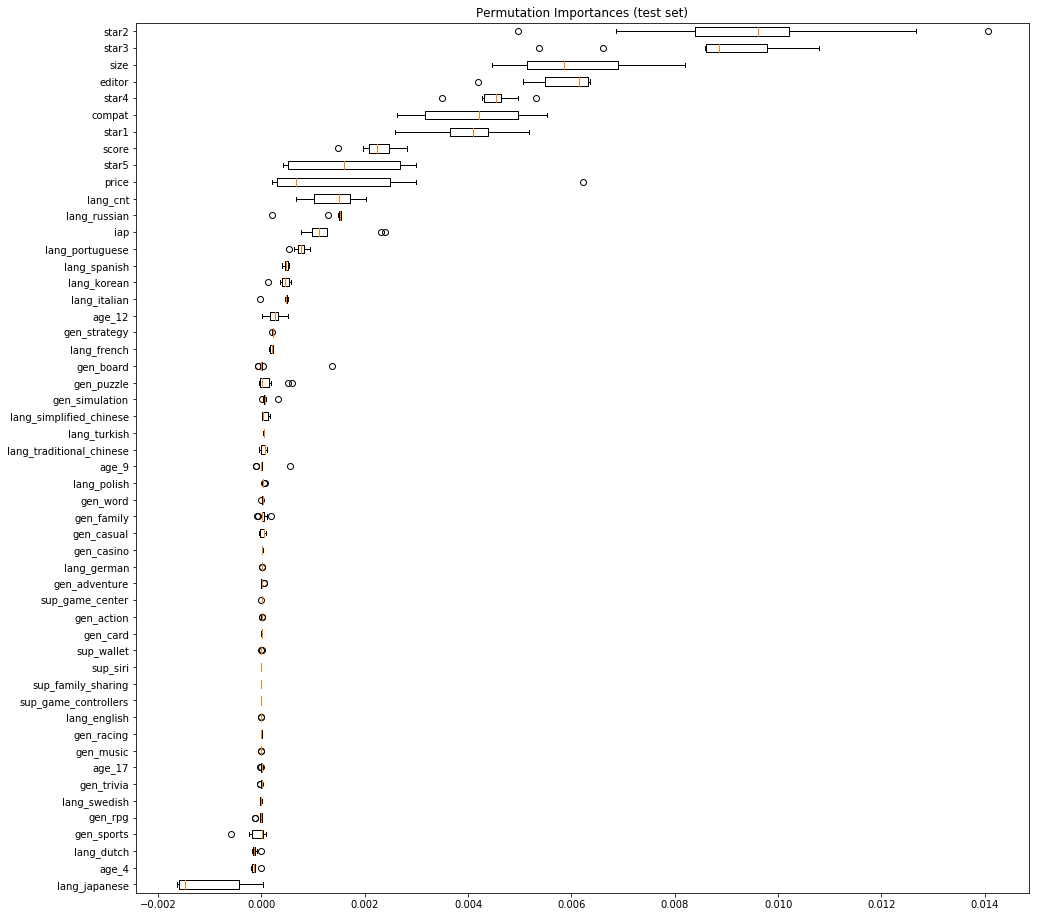

In [479]:
from sklearn.inspection import permutation_importance


result = permutation_importance(estimator, test_set, test_label, n_repeats=10,
                                random_state=42)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(16,16))

ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=test_set.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
plt.show()

In [449]:
examples = ['Where Shadows Slumber', 'Monument Valley',
            'LIMBO', 'Journey', 'Rusty Lake Paradise']

ex = apps[apps['title'].isin(examples)].copy()

ex_summary = ex[['title','author','nrating']].copy()
ex_feat = ex.drop(columns=['nrating','title','author','nrating_cut','list_rank'])
ex_summary['predicted_nrating'] = estimator.predict(ex_feat)

ex_summary

,title,author,nrating,predicted_nrating
97032,Journey,Annapurna Interactive,61.0,185.647939
102552,LIMBO,Playdead,2100.0,2981.833358
117338,Monument Valley,ustwo games,3300.0,4274.849801
148024,Rusty Lake Paradise,Rusty Lake,1100.0,784.839240
187663,Where Shadows Slumber,Game Revenant Ltd,175.0,334.115471


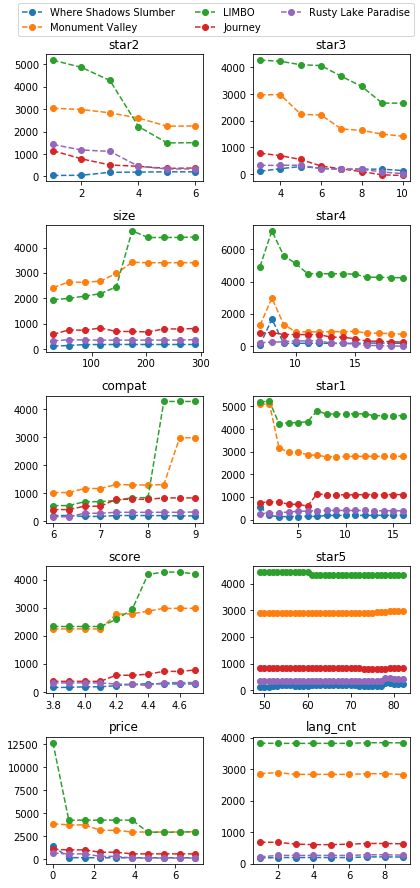

In [474]:
fig, axs = plt.subplots(5,2, figsize=(6, 12))

star_feats = ['star2', 
              'star3',
              'size',
              'star4',
              'compat',
              'star1',
              'score',
              'star5',
              'price',
              'lang_cnt']

float_feats = ['size',
               'compat',
               'score',
               'price']

axs = axs.flatten()

for feat_ind, feat in enumerate(star_feats):
        
    ex_feat = ex.drop(columns=['nrating','title','author','nrating_cut','list_rank'])
#     ex_feat['price'] = 0.00
    
    if feat in float_feats: 
        low_bnd = apps[[feat]].quantile(q=0.15, axis=0).item()
        up_bnd = apps[[feat]].quantile(q=0.85, axis=0).item()
        
        if feat == 'price':
            low_bnd = apps[[feat]].quantile(q=0.01, axis=0).item()
            up_bnd = apps[[feat]].quantile(q=0.99, axis=0).item()
        
        x_rng = np.linspace(low_bnd, up_bnd, num=10)
    
    else:
        low_bnd = apps[[feat]].quantile(q=0.15, axis=0).item()
        up_bnd = apps[[feat]].quantile(q=0.85, axis=0).item()
        x_rng = list(range(int(low_bnd), int(up_bnd)))

    predictions = np.zeros((len(x_rng), len(ex_feat)))

    for ind, val in enumerate(x_rng):
        ex_feat[feat] = val
        predictions[ind,:] = estimator.predict(ex_feat)
    
    fig.tight_layout()
    axs[feat_ind].plot(x_rng, predictions, linestyle='--', marker='o')
    axs[feat_ind].set_title(feat)

fig.legend(examples, loc='upper center', 
                     ncol=3,
                     bbox_to_anchor=(0.5, 1.03))

In [486]:
# fig, axs = plt.subplots(5,2, figsize=(6, 12))

cat_feats = ['editor',
              'iap',
              'lang_russian']

axs = axs.flatten()

for feat_ind, feat in enumerate(cat_feats):
    
    ex_feat = ex.drop(columns=['nrating','title','author','nrating_cut','list_rank'])

    
    predictions = np.zeros((2, len(ex_feat))) #binary category

    for ind, val in enumerate(x_rng):
        ex_feat[feat] = 0
        predictions[0,:] = estimator.predict(ex_feat)
        ex_feat[feat] = 1
        predictions[1,:] = estimator.predict(ex_feat)
    
#     fig.tight_layout()
#     axs[feat_ind].plot(x_rng, predictions, linestyle='--', marker='o')
#     axs[feat_ind].set_title(feat)

# fig.legend(examples, loc='upper center', 
#                      ncol=3,
#                      bbox_to_anchor=(0.5, 1.03))



In [518]:

ex_summary['title'].tolist()

['Journey',
 'LIMBO',
 'Monument Valley',
 'Rusty Lake Paradise',
 'Where Shadows Slumber']

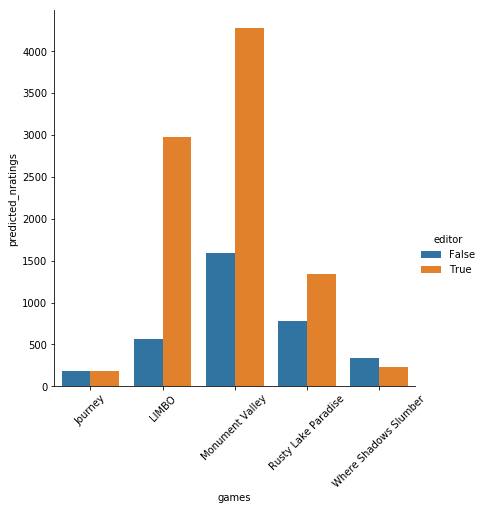

In [523]:
import seaborn as sns


bar_data = ex.drop(columns=['nrating','title','author','nrating_cut','list_rank'])

# bar_data['games'] = examples

bar_data_false = bar_data.copy()
bar_data_false['editor'] = False
bar_data_true = bar_data.copy()
bar_data_true['editor'] = True

bar_data_pred = bar_data_true.append(bar_data_false)
bar_data_pred['predicted_nratings'] = estimator.predict(bar_data_pred)

bar_data_pred['games'] = 2 * ex_summary['title'].tolist()
# bar_data_false['editor'] = bar


# ex_cat_false = ex_feat.copy()
# ex_cat_false['iap'] = 0
# ex_cat_true = ex_feat.copy()
# ex_cat_true['iap'] = 1


# data = {'games': examples,
#         'False': estimator.predict(ex_cat_false),
#         'True': estimator.predict(ex_cat_true)}

# df = pd.DataFrame(data)

g = sns.catplot(x='games', y='predicted_nratings', hue='editor', 
            data=bar_data_pred, kind='bar', height=6)

g.set_xticklabels(rotation=45)

In [507]:
bar_data_pred

,compat,editor,iap,price,score,size,age_12,age_17,age_4,age_9,...,star3,star2,star1,sup_family_sharing,sup_game_center,sup_game_controllers,sup_siri,sup_wallet,predicted_nratings,games
97032,12.0,1,0,4.99,4.1,1100.0,0,0,1,0,...,8.0,3.5,12.0,1,1,0,0,0,185.647939,Where Shadows Slumber
102552,9.0,1,0,3.99,4.6,136.0,1,0,0,0,...,4.0,2.0,4.0,1,1,0,0,0,2981.833358,Monument Valley
117338,9.0,1,1,3.99,4.6,700.1,0,0,1,0,...,3.0,3.0,4.0,1,0,0,0,0,4274.849801,LIMBO
148024,8.0,1,0,2.99,4.7,124.0,1,0,0,0,...,3.0,2.0,2.0,1,0,0,0,0,1344.606789,Journey
187663,9.0,1,0,2.99,4.5,513.5,1,0,0,0,...,5.0,5.0,4.0,1,0,0,0,0,225.326872,Rusty Lake Paradise
97032,12.0,0,0,4.99,4.1,1100.0,0,0,1,0,...,8.0,3.5,12.0,1,1,0,0,0,188.957594,Where Shadows Slumber
102552,9.0,0,0,3.99,4.6,136.0,1,0,0,0,...,4.0,2.0,4.0,1,1,0,0,0,568.948983,Monument Valley
117338,9.0,0,1,3.99,4.6,700.1,0,0,1,0,...,3.0,3.0,4.0,1,0,0,0,0,1592.952782,LIMBO
148024,8.0,0,0,2.99,4.7,124.0,1,0,0,0,...,3.0,2.0,2.0,1,0,0,0,0,784.839240,Journey
187663,9.0,0,0,2.99,4.5,513.5,1,0,0,0,...,5.0,5.0,4.0,1,0,0,0,0,334.115471,Rusty Lake Paradise


In [500]:
bar_data

,compat,editor,iap,price,score,size,age_12,age_17,age_4,age_9,...,star4,star3,star2,star1,sup_family_sharing,sup_game_center,sup_game_controllers,sup_siri,sup_wallet,games
97032,12.0,1,0,4.99,4.1,1100.0,0,0,1,0,...,15.0,8.0,3.5,12.0,1,1,0,0,0,Where Shadows Slumber
102552,9.0,1,0,3.99,4.6,136.0,1,0,0,0,...,8.0,4.0,2.0,4.0,1,1,0,0,0,Monument Valley
117338,9.0,1,1,3.99,4.6,700.1,0,0,1,0,...,6.0,3.0,3.0,4.0,1,0,0,0,0,LIMBO
148024,8.0,0,0,2.99,4.7,124.0,1,0,0,0,...,6.0,3.0,2.0,2.0,1,0,0,0,0,Journey
187663,9.0,0,0,2.99,4.5,513.5,1,0,0,0,...,10.0,5.0,5.0,4.0,1,0,0,0,0,Rusty Lake Paradise


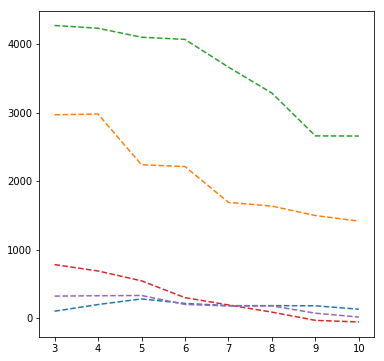

In [375]:
fig = plt.figure(figsize=(6,6))
ax = plt.axes()

ex_feat[feat] = 0
predictions[0,:] = estimator.predict(ex_feat)

ax.plot(star2_rng, predictions, linestyle='--')

In [290]:
predictions

array([1425.56831512, 1178.32870779, 1118.44241953,  453.2505083 ,
        334.11547126,  335.93253047,  331.43815237,  312.90765316,
        312.90765316,  312.90765316,  316.04747913,  316.04747913,
        315.87056511,  315.87056511,  315.07825311,  315.07825311,
        315.07825311,  319.99364404,  318.20733516,  318.20733516,
        318.51844965,  318.51844965,  317.51816537,  317.51816537,
        317.51816537,  317.51816537,  317.51816537,  318.84388781,
        318.84388781,  318.87084888,  318.87084888,  318.87084888,
        318.87084888,  318.87084888,  318.87084888,  318.87084888,
        318.87084888,  318.87084888,  318.87084888,  318.87084888,
        318.87084888,  318.87084888,  318.87084888,  318.87084888,
        318.87084888,  318.87084888,  318.87084888,  318.87084888,
        318.87084888])

In [541]:
wss = apps[apps['title']=='LIMBO'].copy()
wss['nrating']

102552    2100.0
Name: nrating, dtype: float64

In [480]:
apps[apps['title']=='Where Shadows Slumber']

,title,author,compat,editor,iap,list_rank,nrating,price,score,size,...,star4,star3,star2,star1,sup_family_sharing,sup_game_center,sup_game_controllers,sup_siri,sup_wallet,nrating_cut
187663,Where Shadows Slumber,Game Revenant Ltd,9.0,0,0,0,175.0,2.99,4.5,513.5,...,10.0,5.0,5.0,4.0,1,0,0,0,0,2


In [603]:
apps[apps['title']=='Where Shadows Slumber'][['age_4', 'age_9', 'age_12', 'age_17']]
apps[apps['title']=='Where Shadows Slumber'][['star5', 'star4', 'star3', 'star2', 'star1']]
# apps[apps['title']=='Where Shadows Slumber'][['lang_cnt', 'lang_dutch', 'lang_english', 'lang_french',
#        'lang_german', 'lang_italian', 'lang_japanese', 'lang_korean',
#        'lang_polish', 'lang_portuguese', 'lang_russian',
#        'lang_simplified_chinese', 'lang_spanish', 'lang_swedish',
#        'lang_traditional_chinese', 'lang_turkish']]
# apps[apps['title']=='Where Shadows Slumber'][['sup_family_sharing', 'sup_game_center',
#        'sup_game_controllers', 'sup_siri', 'sup_wallet']]
# apps[apps['title']=='Where Shadows Slumber'][['gen_action', 'gen_adventure', 'gen_board', 'gen_card', 'gen_casino',
#        'gen_casual', 'gen_family', 'gen_music', 'gen_puzzle', 'gen_racing',
#        'gen_rpg', 'gen_simulation', 'gen_sports', 'gen_strategy', 'gen_trivia',
#        'gen_word']]
# apps[apps['title']=='Where Shadows Slumber'][['compat', 'editor', 'iap', 'list_rank',
#        'price', 'score', 'size']]

,star5,star4,star3,star2,star1
187663,77.0,10.0,5.0,5.0,4.0


In [537]:
apps[apps['title']=='Monument Valley'][['age_4', 'age_9', 'age_12', 'age_17']]
apps[apps['title']=='Monument Valley'][['star5', 'star4', 'star3', 'star2', 'star1']]
apps[apps['title']=='Monument Valley'][['lang_cnt', 'lang_dutch', 'lang_english', 'lang_french',
       'lang_german', 'lang_italian', 'lang_japanese', 'lang_korean',
       'lang_polish', 'lang_portuguese', 'lang_russian',
       'lang_simplified_chinese', 'lang_spanish', 'lang_swedish',
       'lang_traditional_chinese', 'lang_turkish']]
apps[apps['title']=='Monument Valley'][['sup_family_sharing', 'sup_game_center',
       'sup_game_controllers', 'sup_siri', 'sup_wallet']]
apps[apps['title']=='Monument Valley'][['gen_action', 'gen_adventure', 'gen_board', 'gen_card', 'gen_casino',
       'gen_casual', 'gen_family', 'gen_music', 'gen_puzzle', 'gen_racing',
       'gen_rpg', 'gen_simulation', 'gen_sports', 'gen_strategy', 'gen_trivia',
       'gen_word']]
# apps[apps['title']=='Monument Valley'][['compat', 'editor', 'iap', 'list_rank',
#        'price', 'score', 'size']]

,gen_action,gen_adventure,gen_board,gen_card,gen_casino,gen_casual,gen_family,gen_music,gen_puzzle,gen_racing,gen_rpg,gen_simulation,gen_sports,gen_strategy,gen_trivia,gen_word
117338,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
